In [1]:
import random

from scipy.stats import mode
from copy import deepcopy
from scipy.stats import bernoulli

from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/dnkirill/base/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Часть 1: Передача сигнала, один передатчик, нескоррелированные и скоррелированные ансамбли

Допустим, мы передаём сигнал `1`, но в сети возможны помехи, которые мы моделируем как потерю сигнала (`0`).

In [2]:
P = 0.7
LENGTH = 10

ground_truth = np.array([1] * LENGTH)

def generate_predictions(p, length, random_state=None):
    return bernoulli.rvs(p, size=length, random_state=random_state)

def score(preds, ground_truth):
    return np.sum(preds == ground_truth).astype(int) / LENGTH

Как можно передать сигнал:

* Бейслайн — один передатчик.
* Использовать majority vote для трёх или пяти передатчиков.
* То же самое, но с учётом того, что передатчики могут быть скоррелированы.

### Один передатчик

In [3]:
def single_transmitter(r=1000):
    print('Transmission accuracy: {:.3f}'.format(
        np.mean([score(generate_predictions(P, LENGTH), ground_truth) for _ in range(r)])))

In [4]:
interact(single_transmitter, r=IntSlider(min=1, max=100, value=1, step=5))

interactive(children=(IntSlider(value=1, description='r', min=1, step=5), Output()), _dom_classes=('widget-int…

<function __main__.single_transmitter(r=1000)>

### Несколько передатчиков

Majority voting. Используем hard-voting (т.е., без учёта вероятностей, просто большинством голосующих):

$$ŷ = mode(C_1(X),C_2(X),...,C_m(X))$$

Soft-voting:

$$\hat{y} = \arg \max_i \sum^{m}_{j=1} w_j p_{ij}$$

где $w_j$ — вес, который может применён к классификатору `j`.

### Нескоррелированные передатчики

In [5]:
def voting_clf_predictions(preds):
    return mode(preds).mode[0]

In [6]:
ITER = 50
N_CLF = 3

def clf_acc(n_clf):
    return np.mean([
        score(voting_clf_predictions(np.array([
            generate_predictions(P, LENGTH) for _ in range(n_clf)])), ground_truth)
        for _ in range(ITER)])

print('Transmission accuracy: {:.3f}'.format(clf_acc(N_CLF)))

Transmission accuracy: 0.776


In [7]:
n = list(range(1, 18, 2))
acc = list(map(clf_acc, n))

In [8]:
interact(clf_acc, n_clf=IntSlider(min=1, max=25, value=1, step=2));

interactive(children=(IntSlider(value=1, description='n_clf', max=25, min=1, step=2), Output()), _dom_classes=…

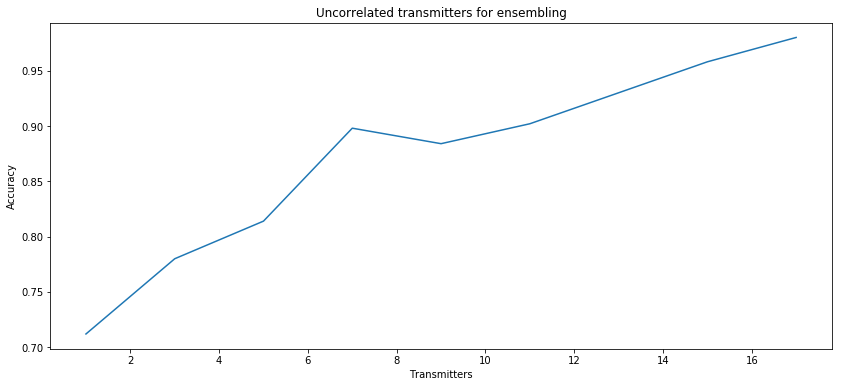

In [9]:
plt.figure(figsize=(14,6))
plt.plot(n, acc)
plt.xlabel('Transmitters')
plt.ylabel('Accuracy')
plt.title('Uncorrelated transmitters for ensembling');

### Скореллированные передатчики

In [10]:
ITER = 1000
N_CLF = 5
DEG_FREEDOM = 1

def clf_acc(n_clf, deg=DEG_FREEDOM):
    preds = []
    for i in range(1, ITER):
        preds_iter = []
        for _ in range(n_clf):
            preds_iter.append(
                generate_predictions(P, LENGTH, random_state=i * np.random.choice(range(deg)))
            )
        preds.append(voting_clf_predictions(preds_iter))
    return np.mean(preds)

print('Transmission accuracy: {:.3f}'.format(clf_acc(N_CLF)))

Transmission accuracy: 0.700


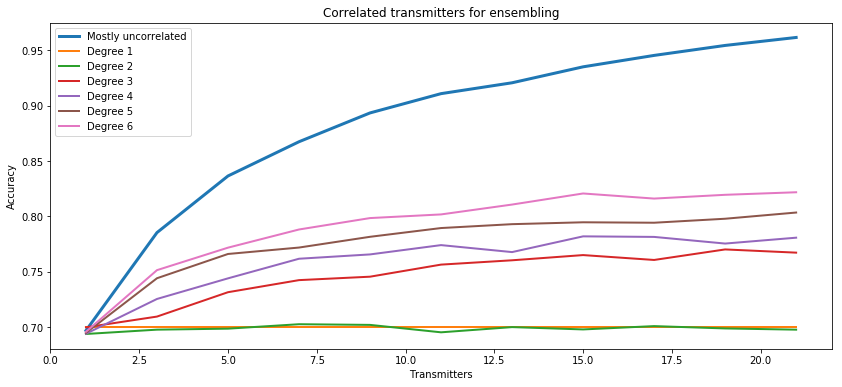

In [11]:
n = list(range(1, 23, 2))
acc = [clf_acc(_n, 99) for _n in n]

plt.figure(figsize=(14,6))
plt.plot(n, acc, label='Mostly uncorrelated', linewidth=3)

for deg in range(1,7):
    n = list(range(1, 23, 2))
    acc = [clf_acc(_n, deg=deg) for _n in n]
    plt.plot(n, acc, label='Degree {}'.format(deg), linewidth=2)

plt.xlabel('Transmitters')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Correlated transmitters for ensembling');

## Часть 2: от дерева решений к RF

In [12]:
from sklearn.datasets import make_classification, make_blobs, make_circles
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
from matplotlib.colors import ListedColormap

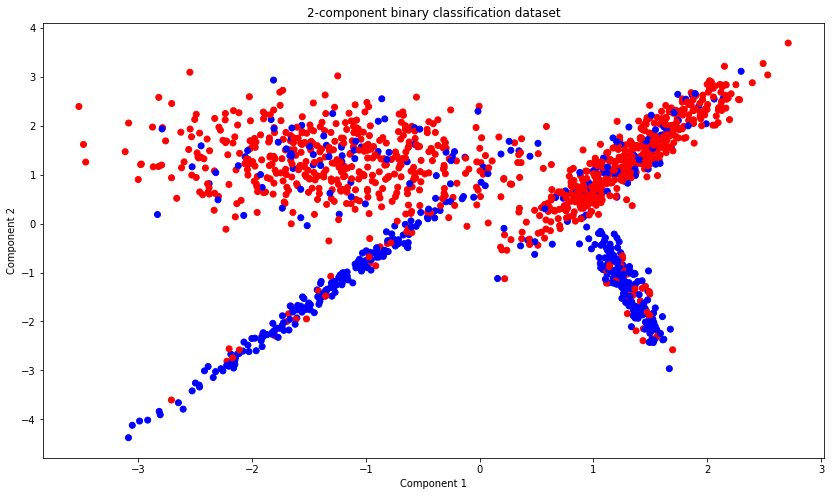

In [13]:
X, y = make_classification(n_samples=1500,
                           n_classes=2,
                           n_features=2,
                           n_redundant=0,
                           n_clusters_per_class=2,
                           weights=[.3,.7],
                           flip_y=0.3,
                           class_sep=1.3,
                           random_state=20190514)

plt.figure(figsize=(14,8))
plt.title('2-component binary classification dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr')
plt.show()

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=20190514)

### Decision Trees

In [15]:
tree_clf_1 = DecisionTreeClassifier(max_depth=20, criterion='gini')

In [16]:
tree_clf_1.fit(X_train, y_train)
y_pred = tree_clf_1.predict_proba(X_val)

In [17]:
roc_auc_score(y_val, y_pred[:,1])

0.7015211023831713

In [18]:
clfs = [
    DecisionTreeClassifier(max_depth=1),
    DecisionTreeClassifier(max_depth=2),
    DecisionTreeClassifier(max_depth=3),
    DecisionTreeClassifier(max_depth=5),
    DecisionTreeClassifier(max_depth=8),
    DecisionTreeClassifier(max_depth=None),
]

In [19]:
labels = ['DT, depth 1', 'DT, depth 2', 'DT, depth 3', 'DT, depth 5', 'DT, depth 25', 'DT, depth unlim']

In [20]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_six_tree_clfs(clfs, names, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val):

    plt.figure(figsize=(16,10))

    h = .02

    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    for i, (name, clf) in tqdm(enumerate(zip(names, clfs))):
        clf.fit(X_train, y_train)
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        Z = Z.reshape(xx.shape)

        ax = plt.subplot(2, len(clfs) / 2, i + 1)
        y_pred = clf.predict_proba(X_val)
        auc = roc_auc_score(y_val, y_pred[:,1])
        plt.title('#{}: {}. ROC AUC: {:.2f}'.format(i, name, auc))
        ax.contourf(xx, yy, Z, cmap='bwr', alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr',
                   edgecolors='k')
        # and testing points
        ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='bwr',
                   edgecolors='k', alpha=0.6)



    plt.tight_layout()
    plt.show()

In [21]:
plot_six_tree_clfs(clfs, labels)

6it [00:00, 20.64it/s]


### Bootstrap—a subsampling with replacement

In [22]:
from sklearn.ensemble import BaggingClassifier

/Users/dnkirill/base/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
clfs = [
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8), n_estimators=100, oob_score=True),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, oob_score=True)
]

names = ['Bootstrap, DT (1, 100)',
         'Bootstrap, DT (2, 100)',
         'Bootstrap, DT (3, 100)',
         'Bootstrap, DT (5, 100)',
         'Bootstrap, DT (8, 100)',
         'Bootstrap, DT (None, 100)']

6it [00:05,  1.04it/s]


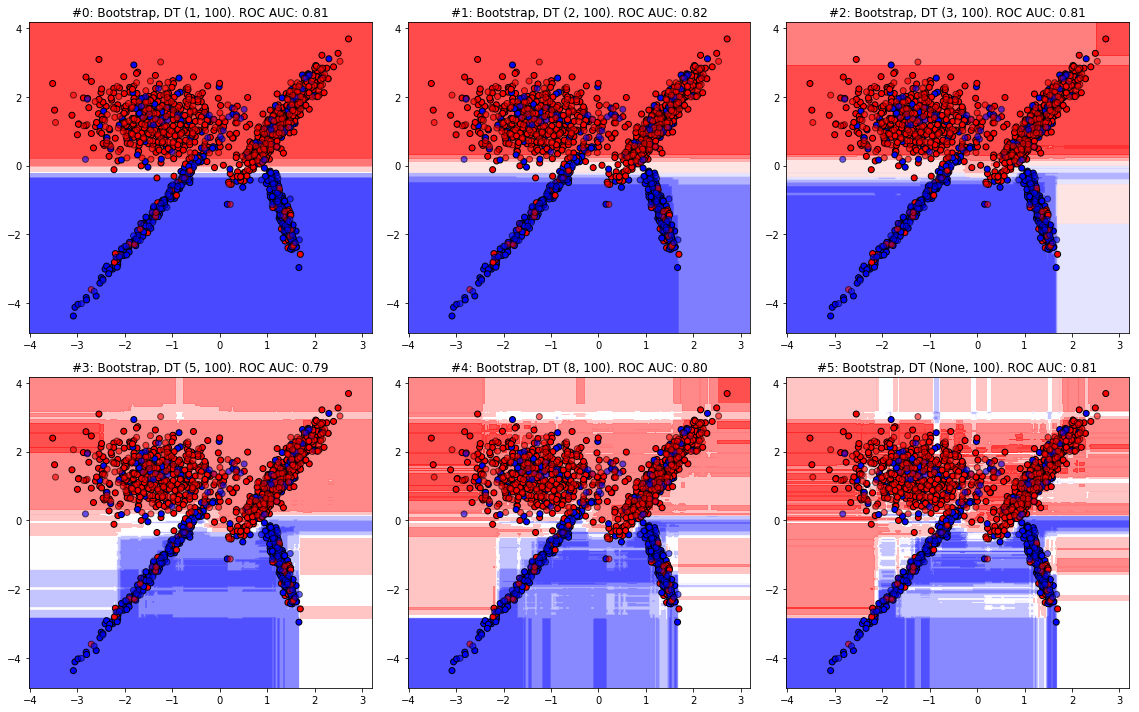

In [24]:
# Bootstrapped samples, no randomization
plot_six_tree_clfs(clfs, names=names)

### Bootstrap with features randomization

In [25]:
# Same estimator building technique, various n_estimators

clfs = [
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), max_features=1, n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), max_features=1, n_estimators=3000)
]

names = ['Bagging, sub, (1, 100)',
         'Bagging, sub, (2, 100)',
         'Bagging, sub, (3, 100)',
         'Bagging, sub, (5, 100)',
         'Bagging, sub, (None, 100)',
         'Bagging, sub, (None, 3000)']

6it [00:37, 10.56s/it]


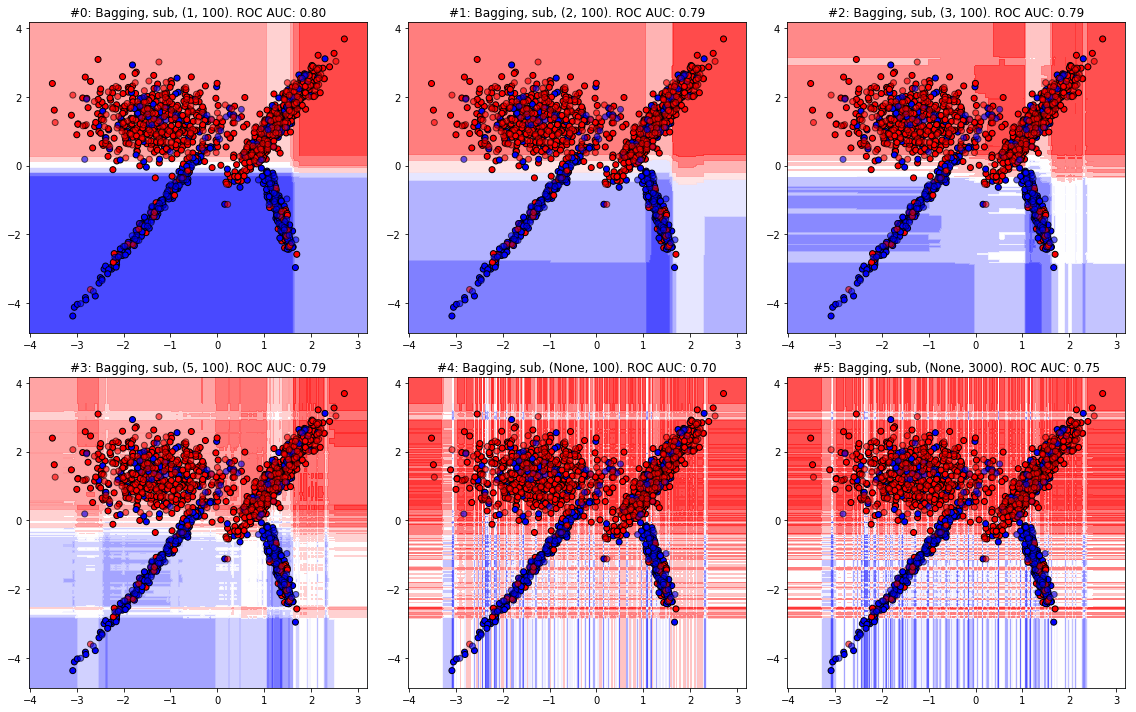

In [26]:
plot_six_tree_clfs(clfs, names=names)

### Bootstrap with feature randomization on each split

In [27]:
clfs = [
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8, max_features=1), n_estimators=1000),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None, max_features=1), n_estimators=1000)
]

names = ['Bagging, sub/each_split, (1, 100)',
         'Bagging, sub/each_split, (2, 100)',
         'Bagging, sub/each_split, (3, 100)',
         'Bagging, sub/each_split, (5, 100)',
         'Bagging, sub/each_split, (8, 1000)',
         'Bagging, sub/each_split, (None, 1000)']

In [28]:
plot_six_tree_clfs(clfs, names)

6it [00:22,  5.28s/it]


### Same as above, only for depth=5 (optimal)

In [29]:
clfs = [
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=10),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=50),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=100),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=500),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=2000),
    BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, max_features=1), n_estimators=4000)
]

names = ['Bagging, sub/each_split, (5, 10)',
         'Bagging, sub/each_split, (5, 50)',
         'Bagging, sub/each_split, (5, 100)',
         'Bagging, sub/each_split, (5, 500)',
         'Bagging, sub/each_split, (5, 2000)',
         'Bagging, sub/each_split, (5, 4000)']

In [30]:
plot_six_tree_clfs(clfs, names)

6it [00:56, 14.64s/it]


### Сравните с Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
# Same estimator building technique, various n_estimators

clfs = [
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=50, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=500, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=2000, max_features=1),
    RandomForestClassifier(max_depth=5, n_estimators=4000, max_features=1),
]

names = ['RF, (5, 10)',
         'RF, (5, 50)',
         'RF, (5, 100)',
         'RF, (5, 500)',
         'RF, (5, 2000)',
         'RF, (5, 4000)']

In [33]:
plot_six_tree_clfs(clfs, names)

6it [00:51, 13.29s/it]


----

## Данные об оттоке из игры

In [34]:
import pandas as pd

dfx = pd.read_csv('data/x_train.csv', sep=';')
dfy = pd.read_csv('data/y_train.csv', names=['target'])

In [35]:
X = dfx.values
y = dfy.values.flatten()

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [37]:
dfx.head().T

0             1         2  \
maxPlayerLevel                      3.900000e+01  2.100000e+01       5.0   
numberOfAttemptedLevels             1.000000e+01  2.200000e+01       6.0   
attemptsOnTheHighestLevel           3.000000e+00  1.900000e+01       1.0   
totalNumOfAttempts                  1.700000e+01  5.500000e+01       6.0   
averageNumOfTurnsPerCompletedLevel  2.444444e+01  1.704545e+01       8.4   
doReturnOnLowerLevels               1.000000e+00  1.000000e+00       0.0   
numberOfBoostersUsed                5.000000e+00  6.000000e+00       1.0   
fractionOfUsefullBoosters           4.000000e-01  3.333333e-01       1.0   
totalScore                          2.650000e+06  5.614000e+06  857000.0   
totalBonusScore                     1.375000e+03  3.825000e+03    1150.0   
totalStarsCount                     2.100000e+01  5.100000e+01      14.0   
numberOfDaysActuallyPlayed          2.000000e+00  4.000000e+00       1.0   

                                           3         4  
maxPlayerLevel                          21.0       4.0  
numberOfAttemptedLevels                  2.0       5.0  
attemptsOnTheHighestLevel                5.0       1.0  
totalNumOfAttempts                       6.0       5.0  
averageNumOfTurnsPerCompletedLevel      19.0       9.6  
doReturnOnLowerLevels                    0.0       0.0  
numberOfBoostersUsed                     1.0       1.0  
fractionOfUsefullBoosters                0.0       1.0  
totalScore                          120000.0  857000.0  
totalBonusScore                          0.0    1075.0  
totalStarsCount                          1.0      12.0  
numberOfDaysActuallyPlayed               1.0       1.0

In [38]:
dfy.head()

target
0       0
1       1
2       1
3       1
4       0

### Качество на одном дереве

In [39]:
cv = StratifiedKFold(n_splits=4, random_state=20190514)
scoring = 'roc_auc'

In [40]:
model = DecisionTreeClassifier()

In [41]:
depths = range(1, 10)
_, tree_test_scores = validation_curve(model, X, y, 
                                       param_name='max_depth',
                                       param_range=depths, 
                                       scoring=scoring, cv=cv, n_jobs=-1)

In [42]:
plt.plot(depths, tree_test_scores.mean(axis=1))

### Бэггинг над деревьями

In [43]:
from sklearn.ensemble import BaggingClassifier

In [44]:
model = BaggingClassifier(DecisionTreeClassifier(), 
                          n_estimators=50, random_state=20190514)

In [45]:
_, bag_test_scores = validation_curve(model, X, y, 
                                      param_name='base_estimator__max_depth', 
                                      param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=-1)

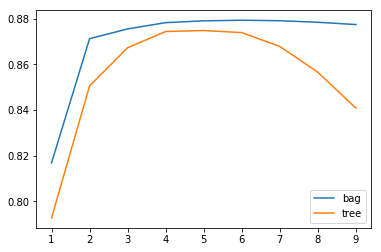

In [46]:
plt.plot(depths, bag_test_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_test_scores.mean(axis=1), label='tree')
plt.legend()

### Случайный лес

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
model = RandomForestClassifier(random_state=20190514, n_estimators=50, 
                               n_jobs=-1)

In [49]:
_, forest_test_scores = validation_curve(model, X, y, 
                                         param_name='max_depth', 
                                         param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=1)

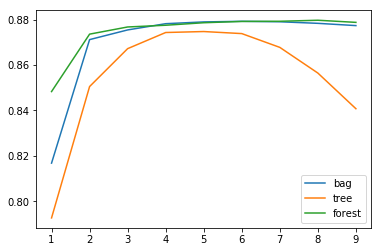

In [50]:
plt.plot(depths, bag_test_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_test_scores.mean(axis=1), label='tree')
plt.plot(depths, forest_test_scores.mean(axis=1), label='forest')
plt.legend()

### Бэггинг можно делать не только над деревьями

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [52]:
cv = StratifiedKFold(n_splits=4, random_state=20190514)
scoring = 'roc_auc'

In [53]:
scores = []
n_est =  [1, 10, 20, 50, 100]
base_model = LogisticRegression(solver='lbfgs')
# base_model = Pipeline([
#     ('scaler', StandardScaler()),
#     ('clf', LogisticRegression(solver='lbfgs'))
# ])

for n in n_est:
    model = BaggingClassifier(base_estimator=base_model,
                              n_estimators=n, 
                              n_jobs=1)
    scores.append(cross_val_score(model, X, y, scoring=scoring, 
                                  cv=cv, n_jobs=1).mean())

## Часть 3: Бустинг

Boosting, в отличие от bagging'а - это **последовательный** способ построения композиции моделей.

Мы постоянно работаем с одним и тем же набором данных, **но** на каждом шаге строим новую базовую модель, которая учитывает ошибки предыдущей модели.<br\>По большому счету, бустинг-алгоритмы отличаются лишь тем, как в них заложен учет этих самых ошибок.

Например в методе **AdaBoost** каждому объекту присваивается вес, который изменяется в зависимости от того, ошиблась ли на нем очередная композиция базовых алгоритмов или нет. Так же веса имеются и у самих базовых моделей, которые штрафуют их за плохие предсказания. Для задачи классификации этот процесс можно проиллюстрировать следующим образом:


<center><img src='ensembles/img/adaboost.png' width='650'></center>

### Формальное описание AdaBoost

#### Обозначения
Введем следующие обозначения:
* $t_k$ - базовый классификатор, полученный на шаге $k$
* $\alpha_k$ - вес базового классификатора, полученного на шаге $k$
* $w_k(i)$ - веса объектов на шаге $k$
* $x_i$ - $i$-й объект, $i = 1, \dots, N$
* $y_i=\{-1, 1\}$ - метки класса для $i$-го объекта 

#### Конечное предсказание
Конечное предсказание получается из взвешенной комбинации предсказания базовых моделей:
$$ T(x^*) = sign(\sum\limits^{K}_{k=1}\alpha_kt_k(x^*)) $$

Наша цель - минимизировать количество ошибок на всей выборке ..

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] $$

.. которые мы мажорируем экспонентой =)

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] \leq \frac{1}{N}\sum\limits_{i=1}^N e^{(-y_i\sum_k\alpha_kt_k(x_i))} $$

Если мы посчитаем ошибки $E_1, E_2, E_3,...$ на каждом шаге, то это даст нам правило для обновления весов объектов. <br\>
А если мы посчитаем производную ошибки $E_t$ по $\alpha_t$, то это даст нам правило для обновления весов базовых моделей. <br\>

#### Алгоритм
Алгоритм обучения **Discrete AdaBoost**:

* Инициализируем веса объектов $w_1(i) = \frac{1}{N}$ 
* Для $k = 1..K$
    * Обучить классификатор $t_k(x) \in \{-1, 1\}$ используя веса объектов $w(i)_k$
    * Вычислить взвешенную ошибку $\epsilon = \frac{\sum_i w_{k}(i)[y_i \neq t_k(x_i) ]}{\sum_i w_{k}(i)}$
    * Вычислить вес базовой модели $\alpha_k = \ln\frac{1-\epsilon}{\epsilon}$
    * Пересчитать веса объектов $w_{k+1}(i) = \frac{w_{k}(i) e^{-\alpha_k y_i t_k(x_i)}}{W}$, $i = 1, \dots, N$,где $W = \sum_i w_k(i) e^{-\alpha_k y_i t_k(x_i)}$ - нормировочная константа.
* $T(x) = sign(\sum_k \alpha_k t_k(x))$

### Демо

In [54]:
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


def ada_demo(n_est=1):

    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,), n_estimators=n_est, learning_rate=0.1)
    ada.fit(X_moons, y_moons)
    

    plt.figure(figsize=(7,5))

    xx1, xx2 = np.meshgrid(np.arange(-1.5, 2.5, 0.1),
                           np.arange(-1, 1.5, 0.1))

    y_hat = ada.predict(np.c_[xx1.ravel(), xx2.ravel()])
    
    y_hat = y_hat.reshape(xx1.shape)

    plt.title('iteration = %d' % n_est )
    plt.contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
    
    plt.show()

In [55]:
X_moons, y_moons = make_moons(noise=0.1)
plt.figure(figsize=(7,5))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)

In [56]:
interact(ada_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), Output()), _dom_classes=('widge…

<function __main__.ada_demo(n_est=1)>

### Применим на наших данных

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=123, test_size=0.2)

In [59]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                         algorithm='SAMME.R',
                         n_estimators=100,
                         learning_rate=0.2, 
                         random_state=20190514)

In [60]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.2, n_estimators=100, random_state=20190514)

In [61]:
scores_train = []
scores_valid = []

for y_pred in ada.staged_predict_proba(X_train):
    scores_train.append(roc_auc_score(y_train, y_pred[:, 1]))
    
for y_pred in ada.staged_predict_proba(X_valid):
    scores_valid.append(roc_auc_score(y_valid, y_pred[:, 1]))

In [62]:
plt.plot(scores_train, label='train score')
plt.plot(scores_valid, label='valid score')
plt.legend()

In [63]:
scores = cross_val_score(ada, X, y, scoring=scoring, cv=cv, n_jobs=-1)
scores.mean()

0.879100400673927

### Градиентный бустинг

По своей структуре метод похож на алгоритм градиентного спуска - отсюда и такое название.

<center><img src='ensembles/img/golf-MSE.png' width=600></center>

<center><img src='ensembles/img/golf-table.svg' width=700></center>

### Формальная постановка задачи

Пусть дана дифференцируемая функция потерь $L(T_k(x), y)$ (для любой задачи - регрессии или классификации)

Функционал качества — $Q(T, y) = \sum_iL(T_k(x_i), y_i) = \sum_iL(T_{k-1}(x_i) + t_{k}(x_i), y_i)$


На секунду представим, что $t_{k}(x_i)$ - это просто вектор значений (значение для каждого объекта). 

Надо "сдвинуть" ответы предыдущей композиции $T_{k-1}$, так чтобы минимизировать функцию потерь (как в градиентном спуске)

Тогда задачу оптимизации $Q(T, y)$ можно решать простым градиентным методом:

* $T_0$ - начальное приближение
* Посчитаем градиент функции потерь $L$: $g_i = \frac{\partial L(T_{k-1}(x_i), y_i)}{\partial T_{k-1}(x_i)}$, $i = 1, \dots, N$ 
* $T_k = T_{k-1} - \alpha g$ - делаем градиентный шаг


Тогда $t_{k}(x) =  \arg\min\limits_{t} \sum\limits_i(t_{k}(x_i) - g_i)^2$, независимо от функции потерь.

### Простое демо

In [64]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def rf_demo(n_est=1, max_depth=1):
    
    np.random.seed(123)
    X = np.random.uniform(-10, 10, 500)

    y = np.sin(X) / X + np.random.normal(0, .1, 500)
    plt.scatter(X, y)
    

    rf = RandomForestRegressor(n_estimators=n_est, max_depth=max_depth)
    
    rf.fit(X.reshape(-1, 1), y)
    
    x_range = np.linspace(X.min(), X.max(), 500).reshape((-1,1))

    y_hat = rf.predict(x_range)
    plt.plot(x_range, y_hat, c='r')
    
    plt.title('Estimators %d' % n_est)
    plt.xlabel('x')
    plt.xlabel('y')
    plt.ylim((-0.5, 1.3))
    plt.xlim(-11,11)
    
    plt.show()

def grad_demo(n_est=1):
    
    np.random.seed(123)
    X = np.random.uniform(-10, 10, 500)

    y = np.sin(X)/X + np.random.normal(0, .1, 500)
    plt.scatter(X, y)
    
    gbr = GradientBoostingRegressor(n_estimators=n_est, learning_rate=0.15)
    gbr_full = GradientBoostingRegressor(n_estimators=200, learning_rate=0.15)
    gbr.fit(X.reshape(-1,1), y)
    gbr_full.fit(X.reshape(-1,1), y)
    
    x_range = np.linspace(X.min(), X.max(), 100).reshape((-1,1))

    for y_hat in gbr.staged_predict(x_range):
        plt.plot(x_range, y_hat, c='g')

    y_hat = gbr_full.predict(x_range)
    
    plt.title('Estimators %d' % n_est)
    plt.plot(x_range, y_hat, c='r')
    plt.xlabel('x')
    plt.xlabel('y')
    plt.ylim((-0.5, 1.3))
    plt.xlim(-11,11)
    
    plt.show()

In [65]:
interact(rf_demo, n_est=IntSlider(min=1, max=150, value=1, step=1),
                  max_depth=IntSlider(min=1, max=10, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), IntSlider(value=1, description=…

<function __main__.rf_demo(n_est=1, max_depth=1)>

In [66]:
interact(grad_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), Output()), _dom_classes=('widge…

<function __main__.grad_demo(n_est=1)>

### Попробуем более сложный датасет

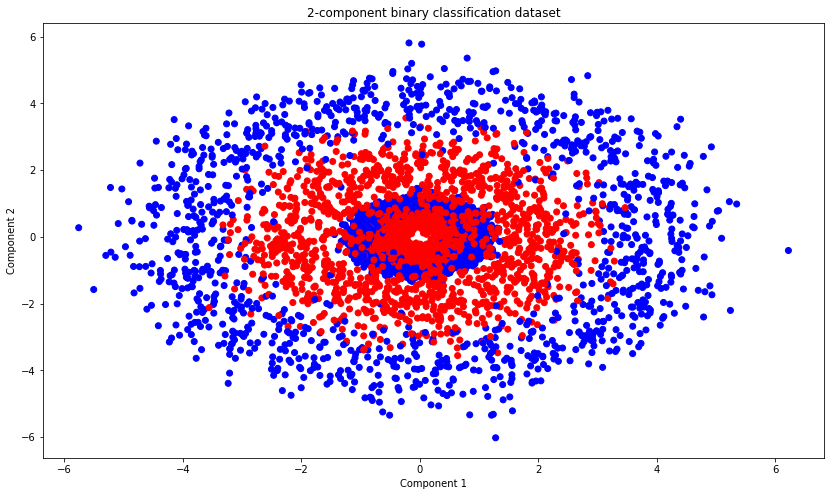

In [67]:
X, y = make_circles(n_samples=2500, noise=0.16, factor=0.55, random_state=20180504)
X2, y2 = make_circles(n_samples=2500, noise=0.16, factor=0.5, random_state=20180504)

X2 = X2 * 4

X2 = np.vstack([X, X2])
y2 = np.hstack([y, y2])
plt.figure(figsize=(14,8))
plt.title('2-component binary classification dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap='bwr')
plt.show()

In [68]:
X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.25, random_state=20180505)

In [69]:
# Random Forest on the new dataset

clfs = [
    RandomForestClassifier(max_depth=2, max_features=1, n_estimators=1),
    RandomForestClassifier(max_depth=2, max_features=1, n_estimators=5),
    RandomForestClassifier(max_depth=2, max_features=1, n_estimators=10),
    RandomForestClassifier(max_depth=3, max_features=1, n_estimators=30),
    RandomForestClassifier(max_depth=3, max_features=1, n_estimators=90),
    RandomForestClassifier(max_depth=3, max_features=1, n_estimators=400),
]

names = ['RF, (2, 1)',
         'RF, (2, 5)',
         'RF, (2, 10)',
         'RF, (3, 30)',
         'RF, (3, 90)',
         'RF, (3, 400)']

In [70]:
plot_six_tree_clfs(clfs, names, X_train, X_val, y_train, y_val)

6it [00:08,  2.34s/it]


In [71]:
from sklearn.ensemble import GradientBoostingClassifier

In [72]:
# Same estimator building technique, various n_estimators

clfs = [
    GradientBoostingClassifier(n_estimators=1, max_depth=2),
    GradientBoostingClassifier(n_estimators=5, max_depth=2, subsample=0.5),
    GradientBoostingClassifier(n_estimators=10, max_depth=2, subsample=0.5),
    GradientBoostingClassifier(n_estimators=30, max_depth=3, subsample=0.5),
    GradientBoostingClassifier(n_estimators=90, max_depth=3, subsample=0.5),
    GradientBoostingClassifier(n_estimators=400, max_depth=3, subsample=0.5),
]

names = ['GBC, (2, 1)',
         'GBC, (2, 5)',
         'GBC, (2, 10)',
         'GBC, (3, 30)',
         'GBC, (3, 90)',
         'GBC, (3, 400)']

6it [00:02,  1.68it/s]


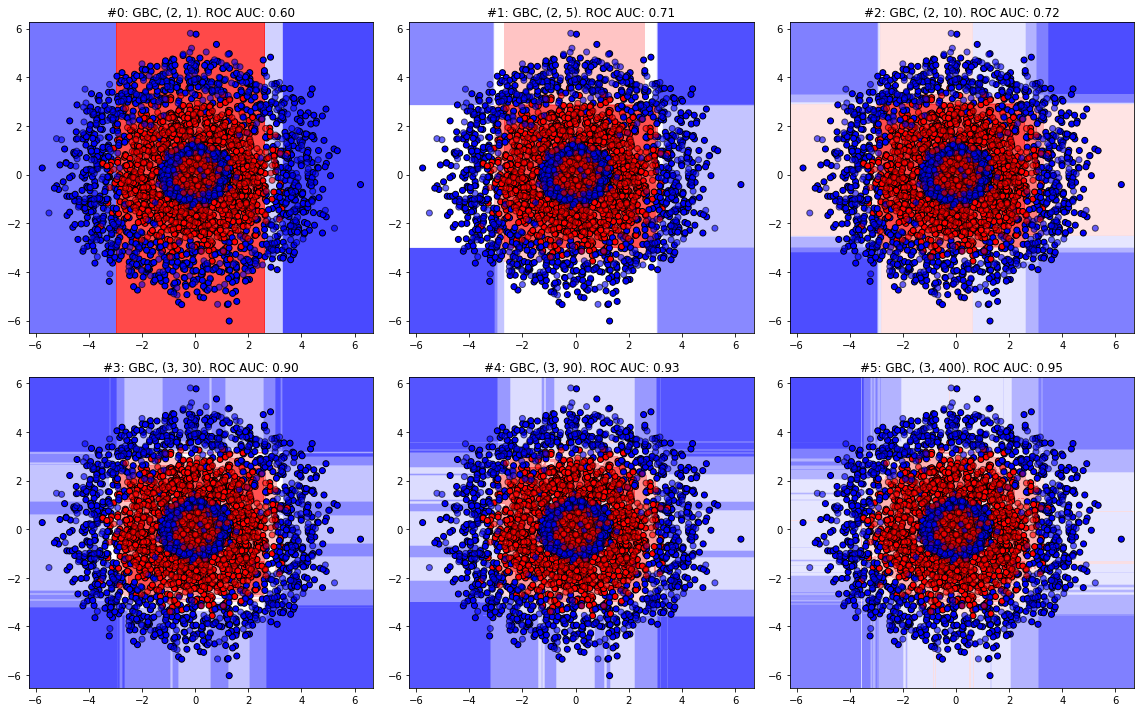

In [73]:
plot_six_tree_clfs(clfs, names, X_train, X_val, y_train, y_val)

In [74]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPClassifier as MLP

clfs = [
    MLPClassifier(hidden_layer_sizes=(10)),
    MLPClassifier(hidden_layer_sizes=(10, 5)),
    MLPClassifier(hidden_layer_sizes=(100, 50)),
    MLPClassifier(hidden_layer_sizes=(200, 100)),
    MLPClassifier(hidden_layer_sizes=(200, 100, 50)),
    MLPClassifier(hidden_layer_sizes=(300, 200, 100)),
]

names = ['MLP, 10',
         'MLP, 30',
         'MLP, 50',
         'MLP, 100',
         'MLP, 150',
         'MLP, 300',]

1it [00:00,  2.11it/s]/Users/dnkirill/base/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
6it [00:15,  2.99s/it]


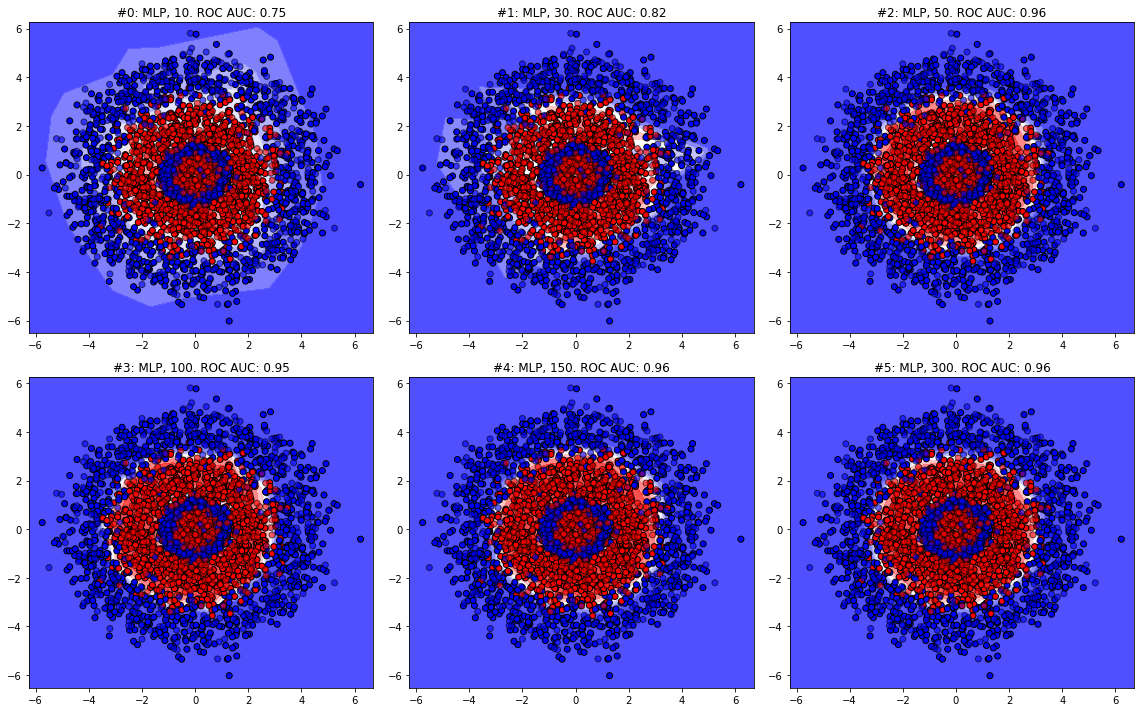

In [75]:
plot_six_tree_clfs(clfs, names, X_train, X_val, y_train, y_val)

In [76]:
from sklearn.svm import SVC

А теперь сравним множество алгоритмов с VotingClassifier и стекингом "из коробки".

Вам понадобится библиотека mlxtend
Рекомендую её _особенно_ для построения наглядных визуализаций (по типу тех, что я показывал на занятии)
- Сама библиотека: http://rasbt.github.io/mlxtend/
- Ссылка на user guide: http://rasbt.github.io/mlxtend/USER_GUIDE_INDEX/

In [77]:
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import cross_val_score

In [78]:
from sklearn.ensemble import VotingClassifier

In [79]:
gb = SVC(C=1.5, kernel='rbf', probability=True)
clf1 = MLP(hidden_layer_sizes=(100, 50))
clf2 = MLP(hidden_layer_sizes=(200, 100, 50))
clf3 = GradientBoostingClassifier(n_estimators=30, max_depth=3, subsample=0.5)
svm = SVC(C=1.5, kernel='rbf', probability=True)
eclf = VotingClassifier([('nn', clf1), ('nn2', clf2), ('gbdt', clf3)], voting='soft')
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, svm], 
                            meta_classifier=gb)

clfs = [clf1, clf2, clf3, svm, eclf, sclf]

In [80]:
names = ['MLP, 100-50',
         'MLP, 200-100-50',
         'GBDT, 30',
         'SVC, RBF',
         'ECLF',
         'SCLF']

6it [00:46, 10.91s/it]


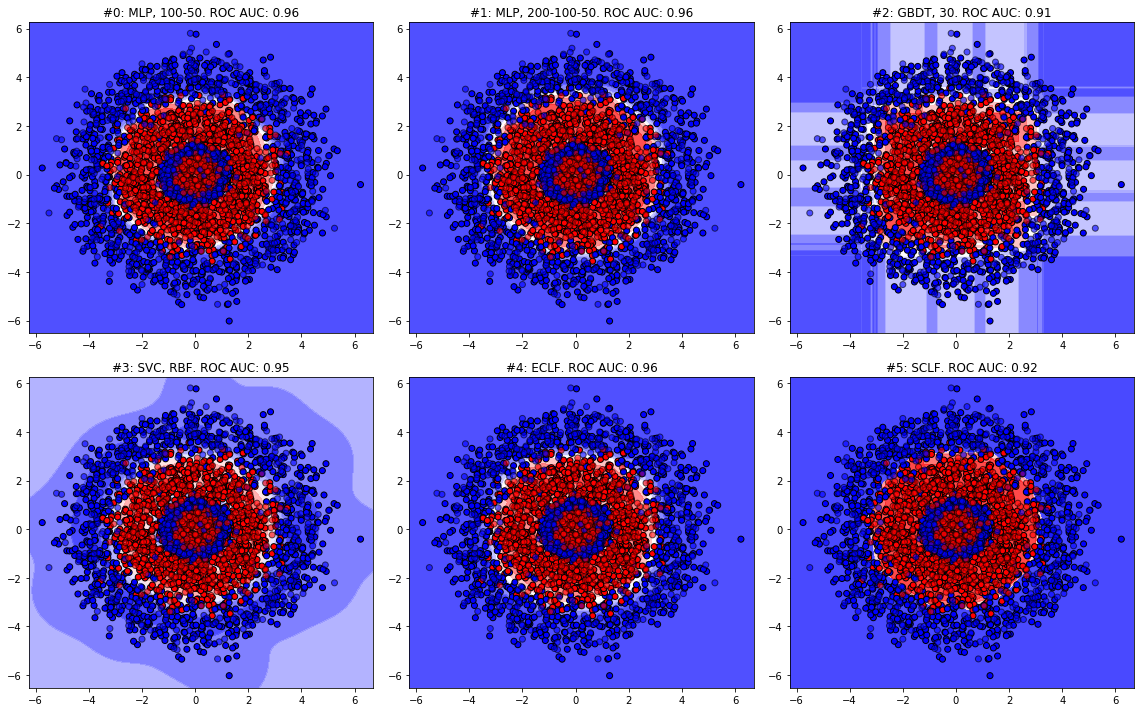

In [81]:
plot_six_tree_clfs(clfs, names, X_train, X_val, y_train, y_val)

In [83]:
for clf, label in zip([clf1, clf2, clf3, eclf, sclf], ['NN', 'NN', 'GBDT', 'Vote', 'Stack']):
    sc = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print('CV: {} for {}'.format(sc.mean(), label))

CV: 0.9135950854700855 for NN
CV: 0.9111931608559307 for NN
CV: 0.8987877006087438 for GBDT


/Users/dnkirill/base/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/dnkirill/base/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/dnkirill/base/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CV: 0.9119925213675214 for Vote
CV: 0.9123950839328537 for Stack
